In [44]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from dotenv import load_dotenv

# Import Utility Functions
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.data.gcs_utils import GCSClient

from collab_env.alignment import align

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup API keys

In [ ]:
# Load environment variables from .env file
load_dotenv()
data_key = os.environ.get("COLLAB_DATA_KEY")
print(f"Data key: {data_key}")

Gerbils key: /workspace/api-keys/collab-gerbils-444419-2c6aa9a47bb5.json
Data key: /workspace/api-keys/collab-data-463313-c340ad86b28e.json


### Download an RGB video

In [3]:
CURRENT_PROJECT = "COLLAB_DATA"
PROJECT_KEY = Path(os.environ.get(f"{CURRENT_PROJECT}_KEY"))
PROJECT_ID = "-".join(PROJECT_KEY.stem.split("-")[:-1])

# Connect to GCS
gcs_client = GCSClient(
    project_id=PROJECT_ID,
    credentials_path=expand_path(PROJECT_KEY.as_posix(), get_project_root()),
)

2025-08-05 17:39:11.361 | INFO     | collab_env.data.gcs_utils:__init__:34 - Using credentials from /workspace/api-keys/collab-data-463313-c340ad86b28e.json
2025-08-05 17:39:11.369 | INFO     | collab_env.data.gcs_utils:__init__:40 - Using project collab-data-463313


Find all buckets and grab the videos for the desired session

In [4]:
CURRENT_SESSION = "2024_02_06"
CURRENT_BUCKET = gcs_client.list_buckets()[1]
DTYPE = 'processed'

assert DTYPE in CURRENT_BUCKET, "Current bucket is not the processed bucket"

# Grab the aligned frames for the current session
current_session_dir = gcs_client.glob(f"{CURRENT_BUCKET}/{CURRENT_SESSION}*")[0]

# Set the current output directory
local_out_dir = get_project_root() / "data" / current_session_dir

Download aligned files and splat environment

In [5]:
# Download aligned frames and environment directories
for dir_name in ["aligned_frames", "environment"]:
    gcs_path = f"{current_session_dir}/{dir_name}"
    local_path = local_out_dir / dir_name

    if not local_path.exists():
        gcs_client.download_folder(gcs_path, local_path)

### Now load the video

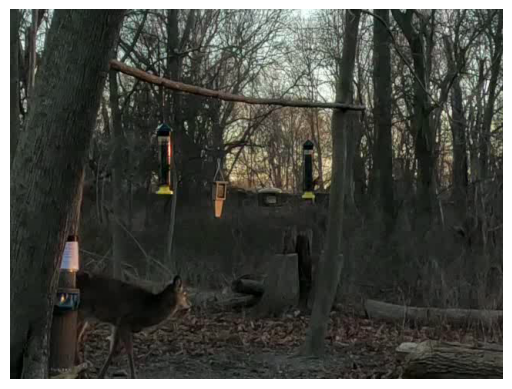

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

aligned_dir = local_out_dir / "aligned_frames" / "rgb_1"
aligned_fn = aligned_dir / "adjusted_rgb_1.mp4"
cap = cv2.VideoCapture(aligned_fn)

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    break

# Double check the frame is correct
plt.imshow(frame)
plt.axis('off')
plt.show()

Write a frame out

In [7]:
# al = (local_out_dir / "aligned_frames/rgb_1/")
sampled_frames_dir = aligned_dir / "sampled"
os.makedirs(sampled_frames_dir, exist_ok=True)

out_fn = sampled_frames_dir / "0001.png"
frame_out = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
cv2.imwrite(out_fn, frame_out)

True

### Import hloc

In [8]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, pairs_from_exhaustive
from hloc.utils.viz import plot_images
from hloc.utils.io import get_keypoints, get_matches
import pycolmap


Configuration for alignment

In [9]:
import collab_env.alignment.align as align

environment_dir = local_out_dir / "environment" # Path to environment directory
preproc_dir = environment_dir / "C0043" / "preproc" # Path to colmap preproc directory
output_dir = local_out_dir / "aligned_splat" # Path to output directory
query_dir = aligned_dir / "sampled" # Path to query directory

Align the new image to the COLMAP fit

In [10]:
poses, logs = align.align_to_colmap(
    preproc_dir=preproc_dir,
    query_dir=query_dir,
    output_dir=output_dir,
    localizer_conf={
        'estimation': {'ransac': {'max_error': 50}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    },
)

Creating output directory...


[2025/08/05 17:39:22 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Extracting features from queries and matching...
Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/collab-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
[2025/08/05 17:39:24 hloc INFO] Finished exporting features.
[2025/08/05 17:39:24 hloc INFO] Found 597 pairs.
[2025/08/05 17:39:24 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 597/597 [00:47<00:00, 12.46it/s]
[2025/08/05 17:40:13 hloc INFO] Finished exporting matches.
Localizing query images...: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


### View the mesh

In [11]:
import open3d as o3d

mesh_dir = local_out_dir / "environment" / "C0043" / "rade-features" / "mesh"
mesh_fn = mesh_dir / "Open3dTSDFfusion_mesh.ply"

mesh = o3d.io.read_triangle_mesh(mesh_fn)
points = np.asarray(mesh.vertices)
colors = np.asarray(mesh.vertex_colors)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Plot from mesh view

In [41]:
def render_scene(mesh, width, height, intrinsic=None, extrinsic=None):
    if not mesh.has_vertex_colors():
        raise ValueError("Mesh does not have vertex colors.")

    # Create renderer
    renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)
    renderer.scene.set_background([1, 1, 1, 1])  # white bg

    # Set material to use vertex colors
    material = o3d.visualization.rendering.MaterialRecord()
    material.shader = "defaultLit"  # or "defaultLit" if lighting desired

    # Add mesh with material
    renderer.scene.add_geometry("mesh", mesh, material)

    # Set up camera
    renderer.setup_camera(intrinsic, extrinsic, width, height)

    # Render
    img = renderer.render_to_image()

    depth_image = renderer.render_to_depth_image(z_in_view_space=True)

    del renderer
    return np.asarray(img), np.asarray(depth_image)

In [42]:
camera_params = align.align_to_mesh(preproc_dir, mesh_dir, poses[0], out_dir=aligned_dir)
w2c = np.linalg.inv(camera_params['c2w'])

image, depth_image = render_scene(mesh, width=camera_params['width'], height=camera_params['height'], intrinsic=camera_params['K'], extrinsic=w2c)

# plt.imshow(image)

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55ce9e8184e0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


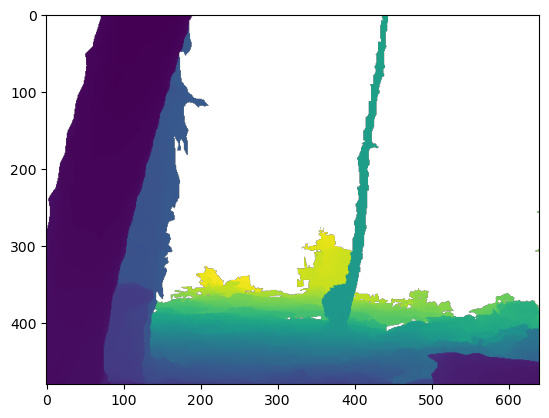

In [43]:
plt.imshow(depth_image)

Map to mesh alignment

Camera Intrinsics:
  Resolution: 640 x 480
  Focal lengths: fx=782.8, fy=856.1
  Principal point: cx=323.4, cy=241.5
  Field of view: 44.5° (horizontal), 31.3° (vertical)
  Aspect ratio: 1.333
Adjusting for non-square pixels (fx=782.8, fy=856.1)
Note: Principal point offset may not be perfectly handled in PyVista


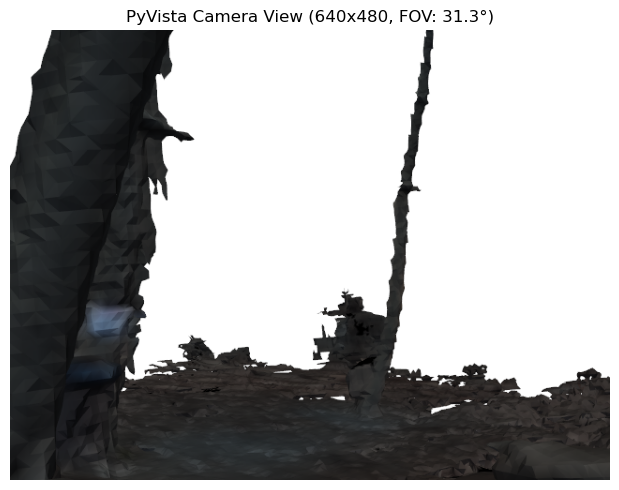

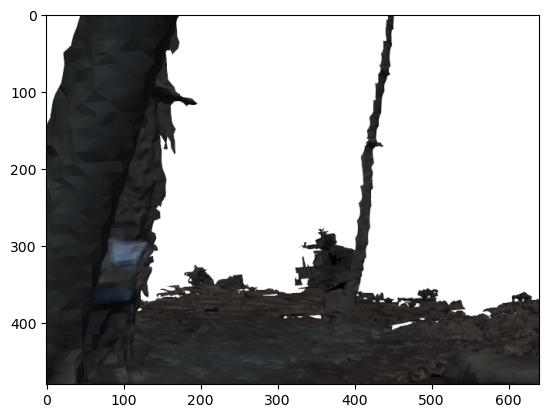

In [28]:
camera_params = align.align_to_mesh(preproc_dir, mesh_dir, poses[0], out_dir=aligned_dir)
camera_params['c2w'][:3, 1:3] *= -1

view_image = align.pyvista_camera_view_with_intrinsics(mesh_fn, camera_params)

plt.imshow(view_image)

### Compute view similarity

In [16]:
import cv2
import numpy as np
import torch
import lpips
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage

def compute_image_similarity(view_image: np.ndarray, frame: np.ndarray, 
                             mask_method='brightness', 
                             background_threshold=240,
                             edge_threshold=50,
                             morphology_kernel_size=3,
                             lpips_net='alex'):
    """
    Compare two RGB images with different backgrounds: view_image (PyVista render) and frame (camera).
    Uses the PyVista render to identify mesh regions (non-white pixels) for focused comparison.

    Args:
        view_image (np.ndarray): HxWx3 RGB PyVista render (mesh=dark, background=white)
        frame (np.ndarray): HxWx3 RGB camera frame 
        mask_method (str): 'brightness_based', 'edge_based', or 'combined'
        background_threshold (int): pixels darker than this are considered mesh (default=240)
        edge_threshold (int): threshold for edge detection
        morphology_kernel_size (int): kernel size for morphological operations
        lpips_net (str): LPIPS network type

    Returns:
        dict: Contains similarity scores and additional info
    """

    view_image = view_image.copy()
    frame = frame.copy()

    # Convert to uint8 if needed
    if view_image.dtype != np.uint8:
        view_image = np.clip(view_image * 255, 0, 255).astype(np.uint8)
    if frame.dtype != np.uint8:
        frame = np.clip(frame * 255, 0, 255).astype(np.uint8)

    # Create mesh mask from PyVista render (dark pixels = mesh, white pixels = background)
    mask = create_foreground_mask(view_image, method=mask_method, 
                                 background_threshold=background_threshold,
                                 edge_threshold=edge_threshold,
                                 kernel_size=morphology_kernel_size)

    # Apply mask to both images for fair comparison
    masked_view, masked_frame = apply_mask_for_comparison(view_image, frame, mask)

    # Calculate SSIM on masked grayscale images
    gray_view = cv2.cvtColor(masked_view, cv2.COLOR_RGB2GRAY)
    gray_frame = cv2.cvtColor(masked_frame, cv2.COLOR_RGB2GRAY)
    
    # Only compute SSIM on valid (non-masked) pixels
    valid_pixels = mask > 0
    if np.sum(valid_pixels) > 100:  # Ensure enough pixels for meaningful comparison
        ssim_score = ssim(gray_view, gray_frame, 
                         data_range=255,
                         gaussian_weights=True,
                         sigma=1.5,
                         use_sample_covariance=False)
    else:
        ssim_score = 0.0

    # Calculate LPIPS on masked images
    lpips_score = compute_masked_lpips(masked_view, masked_frame, mask, lpips_net)

    # Additional metrics
    mesh_coverage = np.sum(mask > 0) / mask.size  # How much of the image contains mesh
    
    return {
        'ssim': ssim_score,
        'lpips': lpips_score,
        'mesh_coverage': mesh_coverage,
        'mesh_mask': mask,
        'masked_view': masked_view,
        'masked_frame': masked_frame
    }


def create_foreground_mask(view_image, method='brightness', background_threshold=240, 
                          edge_threshold=50, kernel_size=3):
    """
    Create a foreground mask to identify mesh regions (non-white pixels) in the PyVista render.
    In PyVista renders, mesh = dark pixels, background = white pixels.
    """
    gray = cv2.cvtColor(view_image, cv2.COLOR_RGB2GRAY)
    
    if method == 'brightness':
        # Mesh pixels are darker than the white background
        # Use < threshold to identify non-white (mesh) pixels
        mask = gray < background_threshold
        
    elif method == 'edge':
        # First get brightness-based mask as base
        brightness_mask = gray < background_threshold
        
        # Use edge detection to refine boundaries
        edges = cv2.Canny(gray, edge_threshold, edge_threshold * 2)
        
        # Dilate edges slightly to capture boundary regions
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilated_edges = cv2.dilate(edges, kernel, iterations=1)
        
        # Combine brightness mask with edge information
        mask = np.logical_or(brightness_mask, dilated_edges).astype(np.uint8)
        
        # Clean up with morphological operations
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        
    elif method == 'combined':
        # Start with brightness thresholding (main approach for PyVista)
        brightness_mask = gray < background_threshold
        
        # Add edge detection for refinement
        edges = cv2.Canny(gray, edge_threshold, edge_threshold * 2)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        edge_mask = cv2.dilate(edges, kernel, iterations=1)
        
        # Combine: brightness mask OR edge mask
        mask = np.logical_or(brightness_mask, edge_mask).astype(np.uint8)
        
        # Clean up the combined mask
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    else:
        raise ValueError(f"Unknown mask method: {method}")
    
    return mask.astype(np.uint8)


def apply_mask_for_comparison(view_image, frame, mask):
    """
    Apply mask to both images for fair comparison.
    Set background pixels to a neutral value.
    """
    masked_view = view_image.copy()
    masked_frame = frame.copy()
    
    # Set masked regions to neutral gray (128) for both images
    neutral_color = 128
    masked_view[mask == 0] = neutral_color
    masked_frame[mask == 0] = neutral_color
    
    return masked_view, masked_frame


def compute_masked_lpips(view_image, frame, mask, lpips_net='alex'):
    """
    Compute LPIPS on masked regions with proper normalization.
    """
    def to_tensor(img):
        img = img.astype(np.float32) / 255.0
        # LPIPS expects values in [-1, 1]
        img = img * 2.0 - 1.0
        return torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()

    tensor_view = to_tensor(view_image)
    tensor_frame = to_tensor(frame)

    # Calculate perceptual similarity
    lpips_fn = lpips.LPIPS(net=lpips_net)
    with torch.no_grad():
        lpips_score = lpips_fn(tensor_view, tensor_frame).item()

    return lpips_score


def visualize_comparison(view_image, frame, result):
    """
    Helper function to visualize the comparison results.
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original images
    axes[0, 0].imshow(view_image)
    axes[0, 0].set_title('View Image (Render)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(frame)
    axes[0, 1].set_title('Frame (Original)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(result['mesh_mask'], cmap='gray')
    axes[0, 2].set_title('Mesh Mask (White=Mesh)')
    axes[0, 2].axis('off')
    
    # Masked images
    axes[1, 0].imshow(result['masked_view'])
    axes[1, 0].set_title('Masked View')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(result['masked_frame'])
    axes[1, 1].set_title('Masked Frame')
    axes[1, 1].axis('off')
    
    # Metrics
    axes[1, 2].text(0.1, 0.8, f"SSIM: {result['ssim']:.4f}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.6, f"LPIPS: {result['lpips']:.4f}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.4, f"Mesh Coverage: {result['mesh_coverage']:.2%}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_title('Metrics')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/envs/collab-env/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


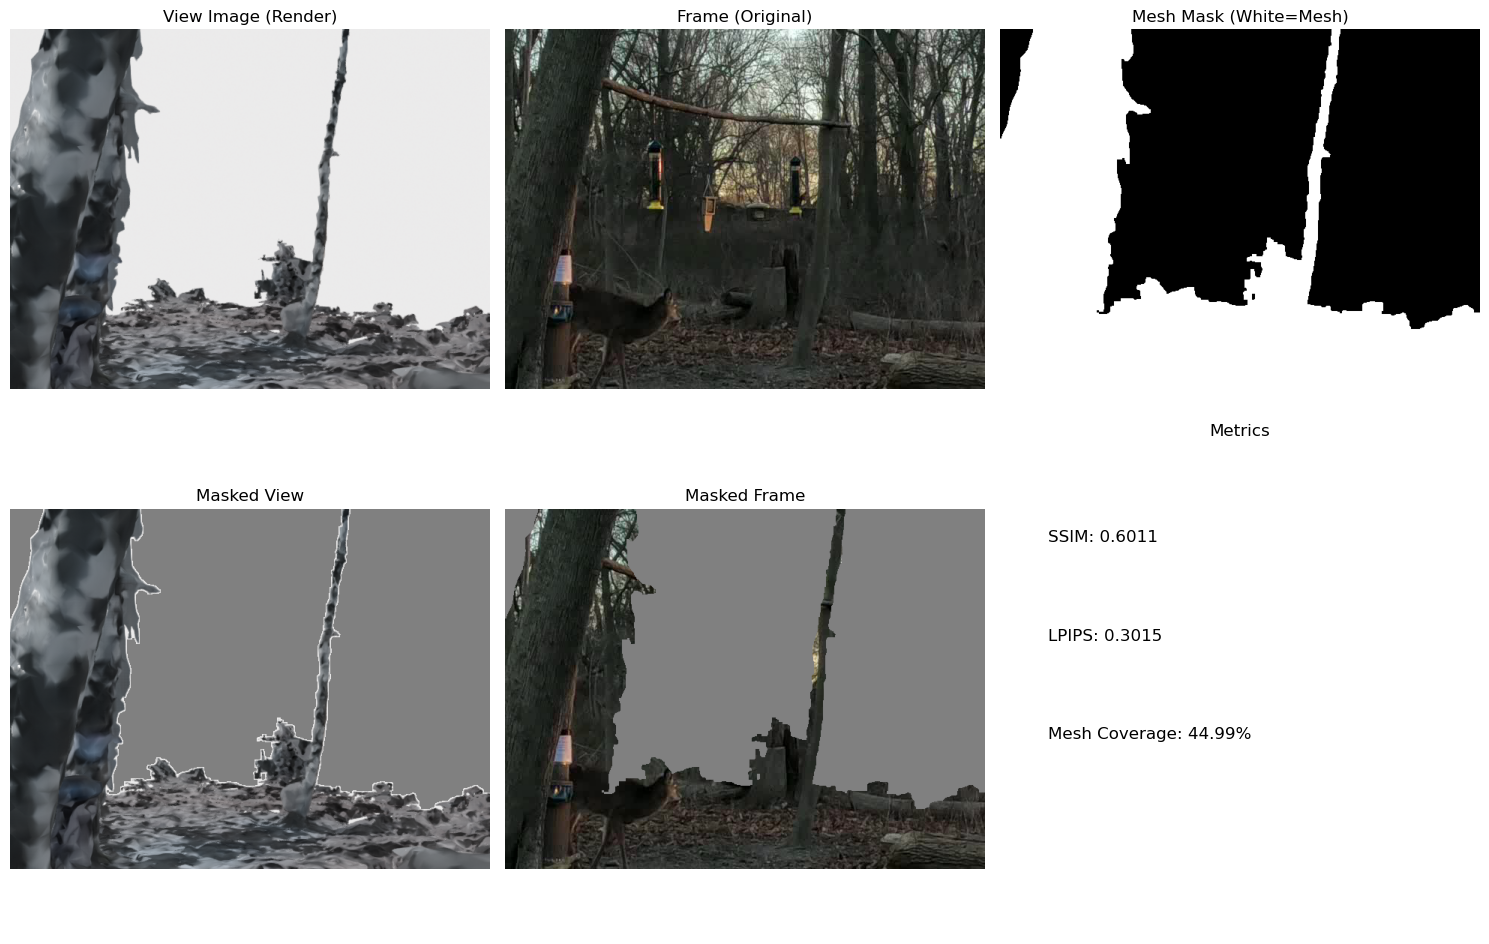

In [39]:
result = compute_image_similarity(image, frame, mask_method='edge', background_threshold=225)

visualize_comparison(image, frame, result)